# Forecasting AI and ML Job Trends

At this stage, train various Traditionl Machine Learning Classification models, and evaluate their performance

## Dependencies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc
)
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

import warnings

Suppress specific FutureWarnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Loading

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd()))
data_dir = os.path.join(project_root, "data")

data_filename = os.path.join(data_dir, "c_job_postings_dataset_cleaned.parquet")
data = pd.read_parquet(data_filename)

print(f"{len(data):,} job postings loaded from {os.path.relpath(data_filename, project_root)}")
data.sample(5)

1,296,381 job postings loaded from data/c_job_postings_dataset_cleaned.parquet


,text,label
285061,parttime middle school mathematics teacher 202...,0
786709,emerging sale executive commercial line produc...,0
633504,restoration superintendent orderly blueteam re...,0
1185254,supervisormanager parttime manager sale claire...,0
602779,midday meal supervisor lunchtime cover driver ...,0


## Handling Class Imballance

In [4]:
labels = data["label"].map({0: "Not AI", 1: "AI"})
labels.value_counts()

label
Not AI    1274405
AI          21976
Name: count, dtype: int64

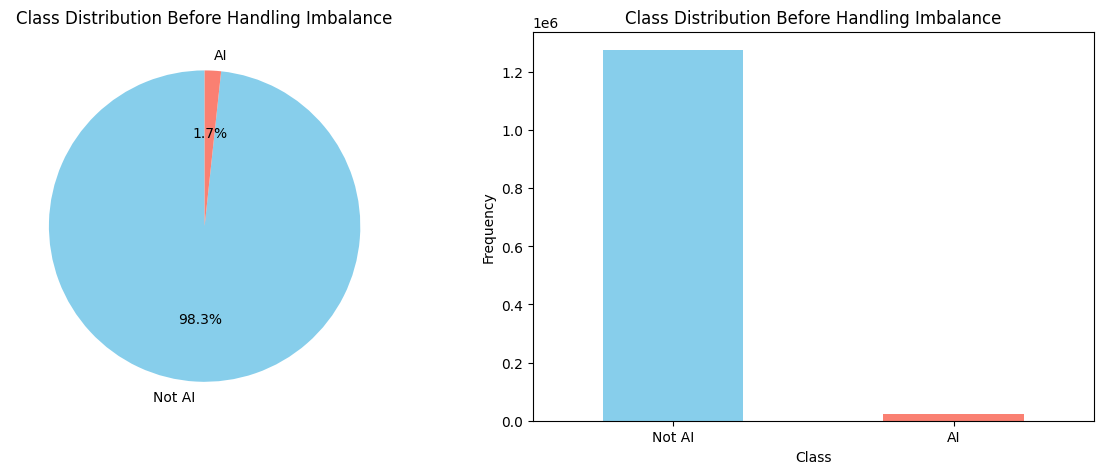

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize the class imbalance before handling - Pie Chart
labels.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Class Distribution Before Handling Imbalance')
axes[0].set_ylabel('')

# Visualize the class imbalance before handling - Bar Chart
labels.value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Class Distribution Before Handling Imbalance')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The dataset exhibits a significant class imbalance, with the "Not AI" class comprising `1,274,405` instances and the "AI" class comprising only `21,976` instances. 
- This imbalance can lead to biased model performance, where the model may favor the majority class.
- To address this issue, we will apply various resampling techniques such as `undersampling the majority class` and `oversampling the minority class`. This will help create a more balanced training set, improving the model's ability to learn from both classes effectively.

### Train/Test Split
When dealing with imbalanced datasets, it is crucial to **split the data into training and testing sets before applying oversampling or undersampling techniques:**

In [6]:
test_size = 0.25

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], data["label"], test_size=test_size, random_state=42
)

### Apply oversampling and undersampling

We will use the best combination from our previous experiment:
- For undersampling, **RandomUnderSampler**
- For oversampling, **ADASYN** or **SMOTE**

In [8]:
undersampler = RandomUnderSampler(sampling_strategy=0.35, random_state=42)
oversampler = ADASYN(random_state=42)

In [9]:
class ImbalanceHandler:
    def __init__(self, data, undersample_method=None, oversample_method=None):
        self.data = data
        self.text_column = 'text'
        self.label_column = 'label'

        # Vectorize text data
        self.vectorizer = TfidfVectorizer(max_features=5000)

        # Set undersampling and oversampling methods
        self.undersample = undersample_method if undersample_method else RandomUnderSampler(sampling_strategy=0.35, random_state=42)
        self.oversample = oversample_method if oversample_method else SMOTE(random_state=42)

        # Create pipeline
        self.pipeline = Pipeline(
            [
                ("tfidf", self.vectorizer),
                ("undersample", self.undersample),
                ("oversample", self.oversample),
            ]
        )

    def handle_imbalance(self):
        # Extract features and labels
        X = self.data[self.text_column]
        y = self.data[self.label_column]

        # Apply the pipeline
        X_res, y_res = self.pipeline.fit_resample(X, y)

        return X_res, y_res

Handle imballances

In [10]:
dataset = pd.DataFrame({"text": X_train, "label": y_train})
imbalance_handler = ImbalanceHandler(
    dataset, undersampler, oversampler
)
X_res, y_res = imbalance_handler.handle_imbalance()

Review class distribution after handling imballance

Class distribution after handling imbalance:
label
0    47220
1    46428
Name: count, dtype: int64


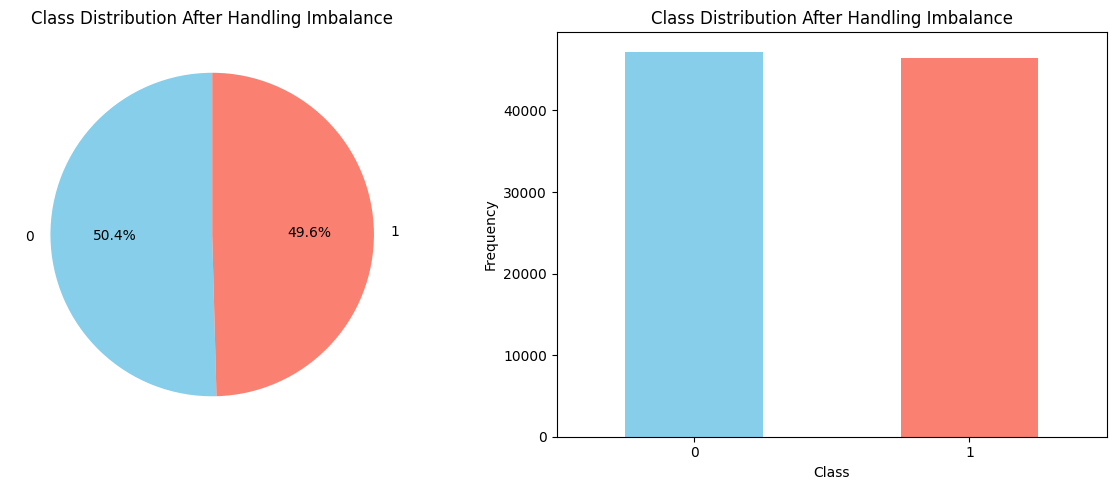

In [11]:
# Review class distribution after handling imbalance
y_res_series = pd.Series(y_res)
class_distribution = y_res_series.value_counts()

print("Class distribution after handling imbalance:")
print(class_distribution)

# Visualize the class distribution after handling imbalance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie Chart
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Class Distribution After Handling Imbalance')
axes[0].set_ylabel('')

# Bar Chart
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Class Distribution After Handling Imbalance')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Classification Models

Evaluate with different ML models

In [12]:
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X_test_vectorized = vectorizer.fit_transform(X_test)

Function to evaluate the model

In [14]:
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

Fit and evaluate the Logistic Regression model

In [15]:
logreg_metrics = fit_and_evaluate_model(logreg_model, X_res, y_res, X_test_vectorized, y_test)

Fit and evaluate the Random Forest model

In [16]:
rf_metrics = fit_and_evaluate_model(rf_model, X_res, y_res, X_test_vectorized, y_test)

Fit and evaluate the LGBM model

In [17]:
lgbm_metrics = fit_and_evaluate_model(lgbm_model, X_res, y_res, X_test_vectorized, y_test)

[LightGBM] [Info] Number of positive: 46428, number of negative: 47220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.314729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535047
[LightGBM] [Info] Number of data points in the train set: 93648, number of used features: 4990
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495771 -> initscore=-0.016915
[LightGBM] [Info] Start training from score -0.016915


 Save the metrics for different models

In [18]:
metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "LightGBM"],
    "Accuracy": [logreg_metrics[0], rf_metrics[0], lgbm_metrics[0]],
    "Precision": [logreg_metrics[1], rf_metrics[1], lgbm_metrics[1]],
    "Recall": [logreg_metrics[2], rf_metrics[2], lgbm_metrics[2]],
    "F1 Score": [logreg_metrics[3], rf_metrics[3], lgbm_metrics[3]],
    "ROC AUC": [logreg_metrics[6], rf_metrics[6], lgbm_metrics[6]]
})

metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.966698,0.024724,0.025509,0.025111,0.537199
1,Random Forest,0.962039,0.088694,0.135621,0.107249,0.745807
2,LightGBM,0.964298,0.029945,0.035786,0.032606,0.500042


Save the results to file

In [22]:
metrics_filename = os.path.join(data_dir, "e_ml_models_performance.csv")
metrics_df.to_csv(metrics_filename, index=False)

print(f"Model performance saved to {os.path.relpath(metrics_filename, project_root)}")

Model performance saved to data/e_ml_models_performance.csv


## Comparative analysis

### ROC Curve Review

ROC curve sorted by ROC AUC

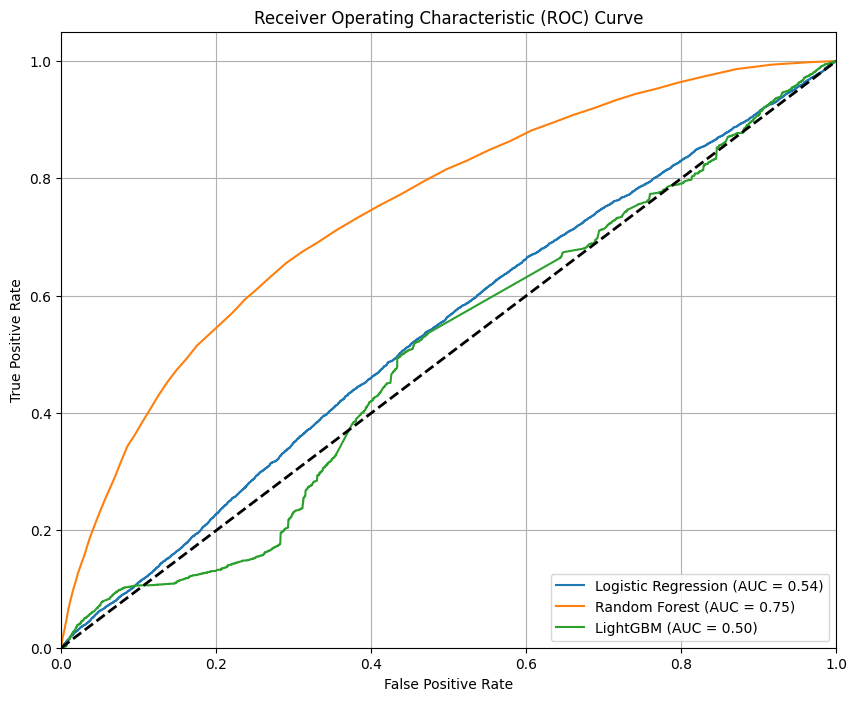

In [20]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    "LightGBM": lgbm_model
}

plot_roc_curves(models, X_test_vectorized, y_test)

### Accuracy Comparison

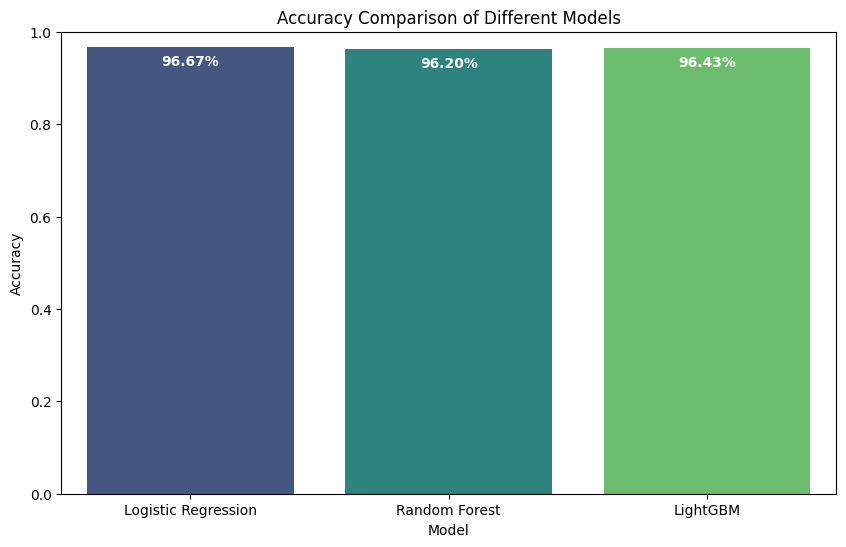

In [21]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Model", y="Accuracy", hue="Model", data=metrics_df, palette="viridis", dodge=False, legend=False)
plt.title("Accuracy Comparison of Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add accuracy values inside the bars with some padding
for p in barplot.patches:
    barplot.annotate(f'{p.get_height() * 100:.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, -10),  # Adjusted to move text inside the bars
                     textcoords='offset points', 
                     color='white', weight='bold')

plt.show()